# Business Analysis for Northwinds Shipping Co.

This is a mock business analysis for Northwinds Shipping Co. The project highlights knowledge of sqlite in Python and knowledge of hypothesis testing to uncover statistically significant differences in business operations.

### Business Questions to answer
- Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

In [1]:
import pandas as pd
import numpy as np
from numpy import std, mean, sqrt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import sqlite3
from sqlite3 import Error
import itertools

from scipy.stats import chi2_contingency
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
from statsmodels.stats.power import TTestIndPower, TTestPower

#File with functions written for the project
from ProjectFunctions import get_sample, get_sample_mean, cohens_d
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

In [2]:
conn = sqlite3.Connection('Northwind_small.sqlite')
cur = conn.cursor()

In [3]:
table_names = pd.read_sql('SELECT name FROM sqlite_master WHERE type="table"', conn)
table_names = table_names.drop([5,8,9], axis=0)

tn_list = table_names.name
select_template = 'SELECT * FROM {name}'
fd = {}
for tn in tn_list:
    query = select_template.format(name = tn)
    fd[tn] = pd.read_sql(query, conn)
    
fd["Order"] = pd.read_sql('''SELECT * FROM "Order"''', conn)

In [4]:
#Making a df for each of the tables generated from the SQL tables

Ordr = pd.DataFrame(fd["Order"])
Employee = pd.DataFrame(fd["Employee"])
Category = pd.DataFrame(fd["Category"])
Customer = pd.DataFrame(fd["Customer"])
Shipper = pd.DataFrame(fd["Shipper"])
Supplier = pd.DataFrame(fd["Supplier"])
Product = pd.DataFrame(fd["Product"])
OrderDetail = pd.DataFrame(fd["OrderDetail"])
Region = pd.DataFrame(fd["Region"])
Territory = pd.DataFrame(fd["Territory"])
EmployeeTerritory = pd.DataFrame(fd["EmployeeTerritory"])

### EDA

![title](Northwind_ERD_updated.png)

In [5]:
#While the above was provided by the company, this code provides heads of all tables
tables = [Ordr, Employee, Category, Customer, Shipper, Supplier, Product, 
          OrderDetail, Region, Territory, EmployeeTerritory]
for i in tables:
    print(i.head())

      Id CustomerId  EmployeeId   OrderDate RequiredDate ShippedDate  ShipVia  \
0  10248      VINET           5  2012-07-04   2012-08-01  2012-07-16        3   
1  10249      TOMSP           6  2012-07-05   2012-08-16  2012-07-10        1   
2  10250      HANAR           4  2012-07-08   2012-08-05  2012-07-12        2   
3  10251      VICTE           3  2012-07-08   2012-08-05  2012-07-15        1   
4  10252      SUPRD           4  2012-07-09   2012-08-06  2012-07-11        2   

   Freight                   ShipName           ShipAddress        ShipCity  \
0    32.38  Vins et alcools Chevalier    59 rue de l'Abbaye           Reims   
1    11.61         Toms Spezialitäten         Luisenstr. 48         Münster   
2    65.83              Hanari Carnes       Rua do Paço, 67  Rio de Janeiro   
3    41.34       Victuailles en stock    2, rue du Commerce            Lyon   
4    51.30           Suprêmes délices  Boulevard Tirou, 255       Charleroi   

       ShipRegion ShipPostalCode ShipC

In [6]:
OrderDetail.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [7]:
OrderDetail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 6 columns):
Id           2155 non-null object
OrderId      2155 non-null int64
ProductId    2155 non-null int64
UnitPrice    2155 non-null float64
Quantity     2155 non-null int64
Discount     2155 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 101.1+ KB


In [8]:
for i in OrderDetail.columns:
    print(i, len(set(OrderDetail[i])))

Id 2155
OrderId 830
ProductId 77
UnitPrice 116
Quantity 55
Discount 11


In [9]:
OrderDetail['Discount'].value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

In [10]:
OrderDetail = OrderDetail[(OrderDetail['Discount'] != 0.06) & (OrderDetail['Discount'] != 0.03) & (OrderDetail['Discount'] != 0.02) & (OrderDetail['Discount'] != 0.01) & (OrderDetail['Discount'] != 0.04)]
OrderDetail.Discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
Name: Discount, dtype: int64

In [11]:
conn = sqlite3.Connection('Northwind_small.sqlite')

od_query = pd.read_sql('''SELECT a.OrderId, a.ProductId, a.UnitPrice, a.Quantity, a.Discount, c.CategoryName 
                          FROM OrderDetail a LEFT JOIN Product b ON a.ProductId = b.ID LEFT JOIN Category c ON b.CategoryId = c.ID
                          WHERE (a.Discount != 0.01 AND a.Discount != 0.02 AND a.Discount != 0.03 AND a.Discount != 0.04 
                          AND a.Discount != 0.06)''', conn)

df = pd.DataFrame(od_query)
df

,OrderId,ProductId,UnitPrice,Quantity,Discount,CategoryName
0,10248,11,14.00,12,0.0,Dairy Products
1,10248,42,9.80,10,0.0,Grains/Cereals
2,10248,72,34.80,5,0.0,Dairy Products
3,10249,14,18.60,9,0.0,Produce
4,10249,51,42.40,40,0.0,Produce
...,...,...,...,...,...,...
2142,11077,52,7.00,2,0.0,Grains/Cereals
2143,11077,55,24.00,2,0.0,Meat/Poultry
2144,11077,66,17.00,1,0.0,Condiments
2145,11077,75,7.75,4,0.0,Beverages


In [12]:
#run ANOVA on discount vs quantity sold
formula = 'Quantity ~ C(Discount)'
lm = ols(formula, df).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                    sum_sq      df         F        PR(>F)
C(Discount)   17348.854662     5.0  9.798709  2.840681e-09
Residual     758138.565924  2141.0       NaN           NaN


In [13]:
def quant_in(pm, disc):
    x = pm - disc
    pm2 = disc / x
    return round(pm2,3)

quant_in(0.2, 0.06)

0.429

In [14]:
pd.crosstab(df['CategoryName'], df['Discount'])

Discount,0.00,0.05,0.10,0.15,0.20,0.25
CategoryName,,,,,,
Beverages,246,26,25,36,39,32
Condiments,131,19,23,17,14,11
Confections,200,29,30,29,17,27
Dairy Products,224,40,25,26,28,22
Grains/Cereals,133,17,10,10,15,10
Meat/Poultry,97,17,20,9,11,19
Produce,91,11,9,10,6,8
Seafood,195,26,31,20,31,25


In [15]:
ct = pd.pivot_table(df, values='Quantity', index=['CategoryName'], columns='Discount')
ct

Discount,0.00,0.05,0.10,0.15,0.20,0.25
CategoryName,,,,,,
Beverages,20.796748,34.538462,29.120000,24.583333,29.230769,23.906250
Condiments,21.320611,37.842105,23.304348,30.529412,22.285714,38.000000
Confections,23.090000,27.413793,18.166667,28.206897,19.882353,29.222222
Dairy Products,22.165179,28.950000,25.960000,28.653846,31.714286,33.727273
Grains/Cereals,22.744361,21.529412,30.500000,23.200000,27.600000,21.800000
Meat/Poultry,20.721649,17.823529,35.200000,31.444444,21.000000,35.157895
Produce,20.956044,30.000000,22.222222,21.800000,21.333333,25.750000
Seafood,21.358974,23.576923,22.548387,37.800000,29.032258,21.720000


In [16]:
z = {}
for i in list(set(df.CategoryName)):
    x = df[df['CategoryName'] == i]
    y = []
    for j in [0.05, 0.10, 0.15, 0.20, 0.25]:
        a = x[x['Discount'] == 0.00]
        b = x[x['Discount'] == j]
        c = round(((b.Quantity.mean() - a.Quantity.mean()) / a.Quantity.mean()) * 100,2)
        y.append(c)
    z[i] = y

z

{'Seafood': [10.38, 5.57, 76.97, 35.93, 1.69],
 'Confections': [18.73, -21.32, 22.16, -13.89, 26.56],
 'Grains/Cereals': [-5.34, 34.1, 2.0, 21.35, -4.15],
 'Beverages': [66.08, 40.02, 18.21, 40.55, 14.95],
 'Dairy Products': [30.61, 17.12, 29.27, 43.08, 52.16],
 'Produce': [43.16, 6.04, 4.03, 1.8, 22.88],
 'Condiments': [77.49, 9.3, 43.19, 4.53, 78.23],
 'Meat/Poultry': [-13.99, 69.87, 51.75, 1.34, 69.67]}

In [17]:
def quant_in(pm, disc):
    x = pm - disc
    pm2 = disc / x
    return round(pm2,2)*100


pm = list(range(30,51,2))
pm = [i/100 for i in pm]
disc = [0, 0.05, 0.1, 0.15, 0.2, 0.25]
a = {}
for i in disc:
    b = []
    for j in pm:
        b.append(quant_in(j, i))
    a[str(i)] = b
import pandas as pd
data = pd.DataFrame.from_dict(a)
data['pm'] = pm
data = data.set_index(['pm'])

data

,0,0.05,0.1,0.15,0.2,0.25
pm,,,,,,
0.30,0.0,20.0,50.0,100.0,200.0,500.0
0.32,0.0,19.0,45.0,88.0,167.0,357.0
0.34,0.0,17.0,42.0,79.0,143.0,278.0
0.36,0.0,16.0,38.0,71.0,125.0,227.0
0.38,0.0,15.0,36.0,65.0,111.0,192.0
0.40,0.0,14.0,33.0,60.0,100.0,167.0
0.42,0.0,14.0,31.0,56.0,91.0,147.0
0.44,0.0,13.0,29.0,52.0,83.0,132.0
0.46,0.0,12.0,28.0,48.0,77.0,119.0


## Is there a difference in mean time to ship?

In [18]:
tts_query = pd.read_sql('''SELECT a.Id, b.CompanyName, a.OrderDate, a.RequiredDate, a.ShippedDate 
                           FROM "Order" a
                           JOIN Shipper b ON a.ShipVia = b.ID''', conn)

df2 = pd.DataFrame(tts_query)
df2

,Id,CompanyName,OrderDate,RequiredDate,ShippedDate
0,10248,Federal Shipping,2012-07-04,2012-08-01,2012-07-16
1,10249,Speedy Express,2012-07-05,2012-08-16,2012-07-10
2,10250,United Package,2012-07-08,2012-08-05,2012-07-12
3,10251,Speedy Express,2012-07-08,2012-08-05,2012-07-15
4,10252,United Package,2012-07-09,2012-08-06,2012-07-11
...,...,...,...,...,...
825,11073,United Package,2014-05-05,2014-06-02,None
826,11074,United Package,2014-05-06,2014-06-03,None
827,11075,United Package,2014-05-06,2014-06-03,None
828,11076,United Package,2014-05-06,2014-06-03,None


In [36]:
df2['ShippedDate'] = pd.to_datetime(df2['ShippedDate'])
df2['OrderDate'] = pd.to_datetime(df2['OrderDate'])
df2['tts'] = df2['ShippedDate'] - df2['OrderDate']
df2['tts'] = df2['tts'].dt.days
df2 = df2[~df2.tts.isna()]
df2.head(2)

,Id,CompanyName,OrderDate,RequiredDate,ShippedDate,tts
0,10248,Federal Shipping,2012-07-04,2012-08-01,2012-07-16,12.0
1,10249,Speedy Express,2012-07-05,2012-08-16,2012-07-10,5.0


In [37]:
for i in set(df2.CompanyName):
    x = df2[df2['CompanyName'] == i]
    print(min(x.tts), max(x.tts))

1.0 37.0
1.0 35.0
1.0 37.0


In [38]:
df2.CompanyName.value_counts()

United Package      315
Federal Shipping    249
Speedy Express      245
Name: CompanyName, dtype: int64

In [39]:
formula = 'tts ~ C(CompanyName)'
lm = ols(formula, df2).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                      sum_sq     df         F    PR(>F)
C(CompanyName)    433.501581    2.0  4.676819  0.009563
Residual        37354.696194  806.0       NaN       NaN


The adjusted p-value is 0.05/3 ~= 0.0167. The p-value of ANOVA is 0.009, which gives us evidence to reject the null that all shippers have the same time to ship. We continue with analysis.

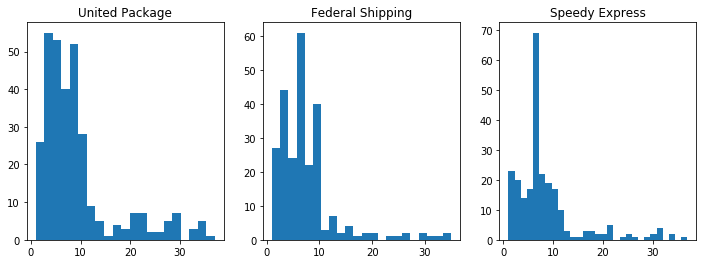

In [51]:
fig, axs = plt.subplots(1,3, figsize = (12,4))
for i in range(0,3):
    x = df2[df2.CompanyName == list(set(df2.CompanyName))[i]]['tts']
    axs[i].hist(x, bins='auto')
    axs[i].set_title(list(set(df2.CompanyName))[i]);